# _Car Evaluation_
## _Tuning Classifer Model with XGBoost_
***

<b>DESCRIPTION</b>

The used car market has significantly grown in recent times, with clients ranging from used car dealers and buyers. You are provided with a car evaluation dataset that has features like price, doors, safety, and so on.

<b>Objective:</b> You are required to create a robust model that allows stakeholders to predict the condition of a used vehicle.

<b>Actions to Perform:</b>

- Predict the condition of a vehicle based on its features.
- Plot the most important features.
- Train multiple classifiers and compare the accuracy.
- Evaluate the XGBoost model with K-fold cross-validation.


## _Import the Required libraries_

In [1]:
import numpy as np
import pandas as pd
import os
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#handle the unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#consistent sized plots unless need of customization
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#enable scrolling and display of all columns
pd.options.display.max_columns = None

## _Load Data and Basic Data Exploration_

In [2]:
#import the csv and display the top rows
cars = pd.read_csv('car_evaluation.csv',delimiter=',',engine='python')
cars.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
#check info 
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


<font color = blue> _There are no null values and all the features and the labels are of type object_</font>

In [4]:
#explit check of null values in the dataset .. 
cars.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [5]:
#check the data balance
cars['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

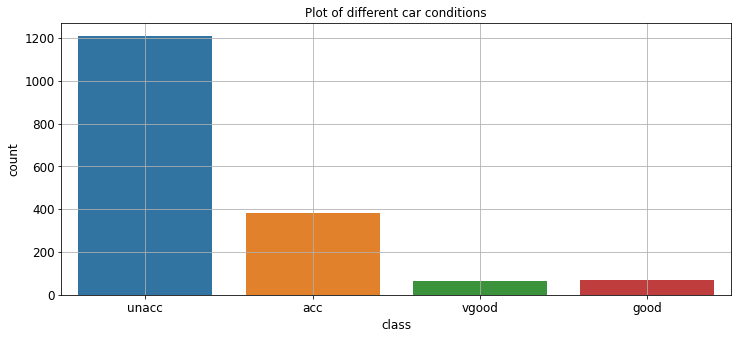

In [6]:
#plot conditions of the cars
sns.countplot(cars['class'])
plt.title('Plot of different car conditions')
plt.grid(True)
plt.show()

_Most of the cars have unacceptable condition. There are relatively fewer good and very good quality cars_

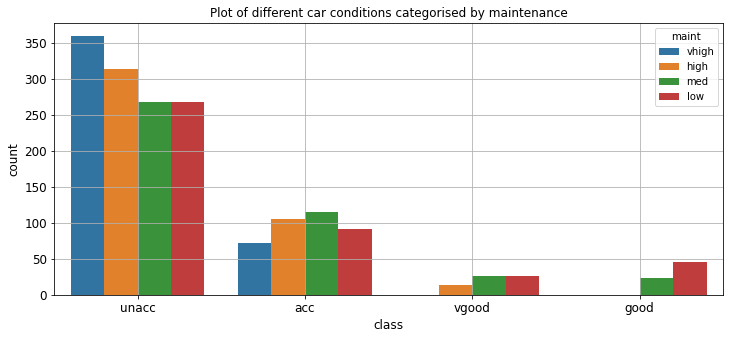

In [7]:
#plot conditions of the cars categorised by the maintenance
sns.countplot(cars['class'],hue=cars['maint'])
plt.title('Plot of different car conditions categorised by maintenance')
plt.grid(True)
plt.show()

_The good and the very good condition cars do not have very high maintenance required. On In fact the good condition cars also do not have any need of high maintenance while there are a few very good condition cars which also need high maintenance._

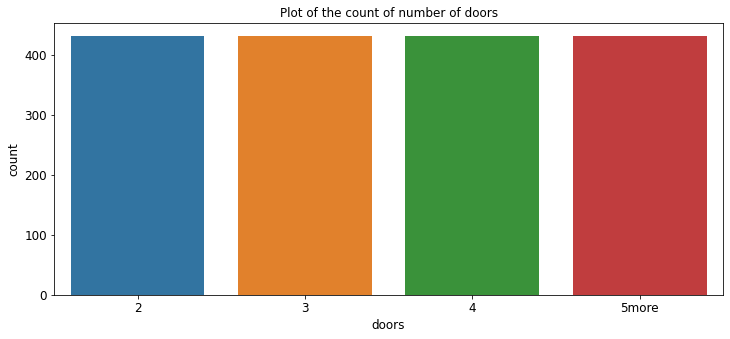

In [8]:
sns.countplot(cars['doors'])
plt.title('Plot of the count of number of doors')
plt.show()

_There is equal number of cars based on the number of doors_

In [9]:
for col in cars.columns:
    print(col)
    print(cars[col].value_counts())

buying
high     432
low      432
med      432
vhigh    432
Name: buying, dtype: int64
maint
high     432
low      432
med      432
vhigh    432
Name: maint, dtype: int64
doors
5more    432
4        432
2        432
3        432
Name: doors, dtype: int64
persons
4       576
2       576
more    576
Name: persons, dtype: int64
lug_boot
small    576
big      576
med      576
Name: lug_boot, dtype: int64
safety
high    576
low     576
med     576
Name: safety, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


_The feature values though all object have numeric and mix of numerica and string values_

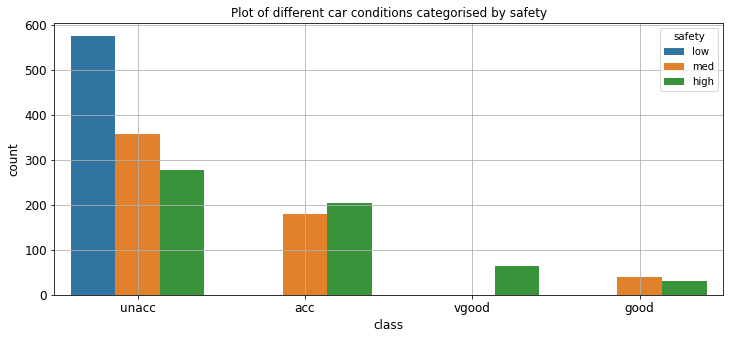

In [10]:
#plot conditions of the cars categorised by the safety
sns.countplot(cars['class'],hue=cars['safety'])
plt.title('Plot of different car conditions categorised by safety')
plt.grid(True)
plt.show()

_Cars in very good condition all have high safety features. Most of the unacceptable cars conditions have low safety features_

## _Split the dataset into train and test set_
<b>_Split the dataset into train and test set such that there is similar proportion or representation of the various car conditions after the split._</b>


In [11]:
from sklearn.model_selection import train_test_split
seed = 51
size = 0.2
train_set,test_set = train_test_split(cars,random_state=seed,test_size=size,stratify=cars['class'])

In [12]:
train_set['class'].value_counts()/len(train_set)

unacc    0.700434
acc      0.222142
good     0.039797
vgood    0.037627
Name: class, dtype: float64

In [13]:
test_set['class'].value_counts()/len(test_set)

unacc    0.699422
acc      0.222543
good     0.040462
vgood    0.037572
Name: class, dtype: float64

In [14]:
#prepare the X_train and y_train
X_train = train_set.drop('class',axis=1)
y_train = train_set['class']
#prepare the X_test and y_test
X_test = test_set.drop('class',axis=1)
y_test = test_set['class']

## _Label Encode the features_

In [15]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [16]:
#fit transform the train and test 
for col in X_train.columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])        

In [17]:
X_train.head(3)

,buying,maint,doors,persons,lug_boot,safety
40,3,3,1,1,1,2
1685,1,1,2,1,2,0
796,0,1,1,1,1,2


In [18]:
#encode the output as models perform better with numerica outputs
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## _Power Transformation and Scaling_




In [19]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

#store the list of columns to be used later for plotting feature importance
columns = X_train.columns
#power transform
pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)
#scale the inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## _Modeling with multiple Models_

In [20]:
#import the model libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#cross valiation and kfold libraries --> chose RepeatedStratified
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold

In [21]:
#define a function to run cross validation across models 
def cross_validate(X = X_train,y = y_train):
    '''This function will run cross validation on multiple models and will print the mean accuracy
       score and the standard deviation.'''
    
    warnings.filterwarnings(action='ignore',message='')

    models = []
    models.append(('RF',RandomForestClassifier()))
    models.append(('SVC',SVC()))
    models.append(('SGD',SGDClassifier()))
    models.append(('xgboost',XGBClassifier()))
        
    results = []
    names = []
    scoring ='accuracy'

    for name,model in models:        
        kfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=5)
        cv_results = cross_val_score(model,X,y,cv=kfold,scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print (f'Model:{name},Mean: {cv_results.mean()},Std Dev: {cv_results.std()}') 


In [22]:
#run cross validation on multiple models ..
cross_validate(X_train,y_train)

Model:RF,Mean: 0.9764070482744239,Std Dev: 0.012342005431664825
Model:SVC,Mean: 0.9110071942446044,Std Dev: 0.02058731798610737
Model:SGD,Mean: 0.6816432071733917,Std Dev: 0.03364550305257529
Model:xgboost,Mean: 0.9905922218746741,Std Dev: 0.008590275512517277


<font color = blue> <b> _Clearly the mean accuracy as well as the mean standard deviation of the XGBoost Classifier model is best compared to the other models. Hence, XGBoost Classifier is the preferred model for further fine tuning and prediction of the test dataset_</b> </font>

## _Plot of Feature Importance_

In [23]:
#fit and predict using the defaut 
model = XGBClassifier(random_state=42)
model.fit(X_train,y_train)
test_predict =  model.predict(X_test)
train_predict = model.predict(X_train)

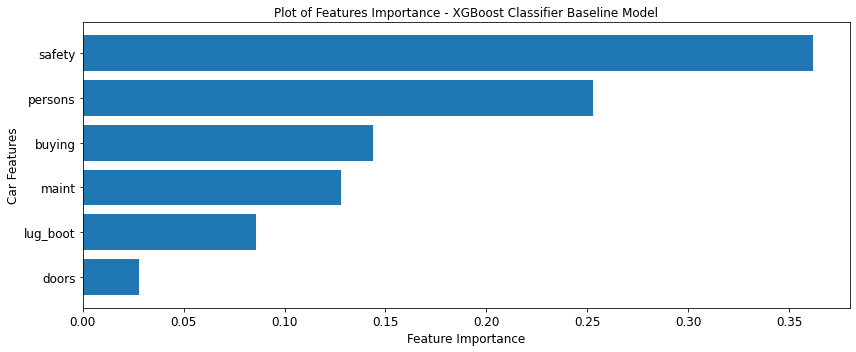

In [24]:
#plot feature importance
#plot the feature importance of random forest model
sorted_idx = model.feature_importances_.argsort()
plt.barh(columns[sorted_idx],model.feature_importances_[sorted_idx])
plt.title('Plot of Features Importance - XGBoost Classifier Baseline Model')
plt.xlabel('Feature Importance')
plt.ylabel('Car Features')
plt.tight_layout()
plt.show()

## _XGBoost Model Fine Tuning_

In [25]:
from sklearn.model_selection import GridSearchCV
#define the parameter grid
param_grid = [{'n_estimators':[100,300], 'max_depth':[5,8], 'learning_rate':[0.1,0.01]}]
#perform grid search
grid_search = GridSearchCV(model,param_grid=param_grid,scoring='accuracy',cv=5,
                           return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=...
                                     objective='multi:softprob',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method=None,
        

In [26]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [27]:
#use the best estimator to train and predict
from sklearn.base import clone
model = clone(grid_search.best_estimator_)

In [28]:
#fit and make predictions
model.fit(X_train,y_train)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

## _Classification Metrics_

In [29]:
#import the libraries
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [30]:
print('Classification Report Test Dataset')
print(classification_report(y_test,test_predict))

Classification Report Test Dataset
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       0.98      1.00      0.99       346
weighted avg       1.00      1.00      1.00       346



In [33]:
train_accuracy = accuracy_score(y_train,train_predict)
test_accuracy = accuracy_score(y_test,test_predict)
print('Accuracy, Train:%.3f  Accuracy, Test:%.3f'%(train_accuracy,test_accuracy))

Accuracy, Train:1.000  Accuracy, Test:0.997


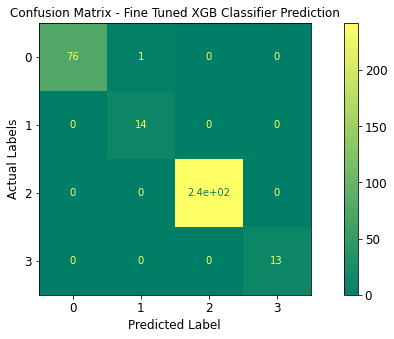

In [32]:
plot_confusion_matrix(model,X_test,y_test,cmap=plt.get_cmap('summer'))
plt.title('Confusion Matrix - Fine Tuned XGB Classifier Prediction')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Label')
plt.show()

<font color = blue> _The accuracy of the XGBoost Classifier fine tuned has 100% accuracy on the train and 99.7% accuracy on the test dataset. There is only 1 instance where the 0 label is predicted as 1_ </font>